In [49]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime, date, time, timedelta

#for models
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import auto_arima


#for PCA & PLS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

#for Data
import yfinance as yf

#for Data Distribution
from scipy.stats import kurtosis, skew, shapiro
from scipy import stats

# for visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
import seaborn as sns


In [50]:
# Fetch historical data for the S&P 500
sp500_data = yf.download('^GSPC', start='2002-01-01', end='2021-01-01')

[*********************100%%**********************]  1 of 1 completed


In [51]:
len(sp500_data)

4784

Check NA Values

In [52]:
# Check for NaN values in the data
nan_values_df = sp500_data.isna().any()

print("NaN values in DataFrame:")
print(nan_values_df)

NaN values in DataFrame:
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [53]:
#Simple Moving Average:
#returns the dataframe with additional coumn of simple moving average
def calculate_sma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Simple Moving Average (SMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate SMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with SMA column added.
    """
    # Calculate SMA
    sma = df[column].rolling(window=window_size, min_periods=1).mean()
    
    # Create a DataFrame to store SMA
    df['SMA'] = sma
    df['SMA_signal'] = df['Close'] - df['SMA']
    return df

In [54]:
#Weighted Moving Average
def calculate_wma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Weighted Moving Average (WMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate WMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with WMA and WMA signal columns added.
    """
    # Generate the weights
    weights = np.arange(1, window_size + 1)
    data = df[column]
    
    # Calculate the WMA using convolution
    wma = data.rolling(window=window_size).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    # Create a DataFrame to store WMA
    df['WMA'] = wma
    
    # Add WMA signal column
    df['WMA_signal'] = df[column] - wma

    
    return df

In [55]:
#MACD
def calculate_macd(df: pd.DataFrame, short_window:int=12, long_window:int=26, signal_window:int=9, column: str = 'Adj Close') -> pd.DataFrame:
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        short_window (int): The short-term window size for the short EMA.
        long_window (int): The long-term window size for the long EMA.
        signal_window (int): The window size for the signal line EMA.

    Returns:
        DataFrame: DataFrame with additional columns for MACD and signal line.
    """
    # Calculate short-term EMA
    short_ema = df[column].ewm(span=short_window, min_periods=1, adjust=False).mean()
    
    # Calculate long-term EMA
    long_ema = df[column].ewm(span=long_window, min_periods=1, adjust=False).mean()
    
    # Calculate MACD line
    macd_line = short_ema - long_ema
    
    # Calculate signal line
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    
    # Store MACD and signal line in the DataFrame
    df['MACD'] = macd_line
    df['Signal Line'] = signal_line
    df['macd_signal'] = macd_line - signal_line
    return df

In [56]:
#Stochastic_oscillator
def calculate_stochastic_oscillator(df, k_fast_period=14, k_slow_period=3, d_slow_period=3, column: str = 'Adj Close'):
    """
    Calculate the Stochastic Oscillator and its corresponding moving averages (K and D lines).

    Parameters:
        df (DataFrame): DataFrame containing the data.
        k_fast_period (int): The period for the fast %K line.
        k_slow_period (int): The period for the slow %K line.
        d_slow_period (int): The period for the slow %D line.

    Returns:
        DataFrame: DataFrame with additional columns for %K_fast, %K_slow, %D_fast, and %D_slow.
    """
    # Calculate highest high and lowest low over the period
    HH = df['High'].rolling(window=k_fast_period).max()
    LL = df['Low'].rolling(window=k_fast_period).min()

    # Calculate %K_fast
    df['%K_fast'] = ((df[column] - LL) / 
                     (HH - LL)) * 100
    
    # Calculate %K_slow (smoothed %K_fast)
    df['%K_slow'] = df['%K_fast'].rolling(window=k_slow_period).mean()
    
    # Calculate %D_fast (3-day SMA of %K_slow)
    df['%D_fast'] = df['%K_slow'].rolling(window=d_slow_period).mean()
    
    # Calculate %D_slow (3-day SMA of %D_fast)
    df['%D_slow'] = df['%D_fast'].rolling(window=d_slow_period).mean()
    
    return df

In [57]:
#RSI
def calculate_rsi(df, window_size=14, column: str = 'Adj Close'):
    """
    Calculate the Relative Strength Index (RSI) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating RSI.

    Returns:
        DataFrame: DataFrame with an additional column for RSI.
    """
    # Calculate price changes
    delta = df[column].diff()
    
    # Define up and down moves
    gain = (delta.where(delta > 0, 0)).rolling(window=window_size).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_size).mean()
    
    # Calculate the relative strength (RS)
    rs = gain / loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Store RSI in the DataFrame
    df['RSI'] = rsi
    
    return df

In [58]:
#WPR
def calculate_williams_percent_r(df, window=14, column: str = 'Adj Close'):
    """
    Calculate the Williams %R (WPR) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating WPR.

    Returns:
        DataFrame: DataFrame with an additional column for WPR.
    """
    # Calculate highest high and lowest low over the window
    highest_high = df['High'].rolling(window=window).max()
    lowest_low = df['Low'].rolling(window=window).min()
    
    # Calculate Williams %R
    wpr = ((highest_high - df[column]) / (highest_high - lowest_low)) * -100
    
    # Store WPR in the DataFrame
    df['WPR'] = wpr
    
    return df

In [59]:
#Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2, column: str = 'Adj Close'):
    """
    Calculate Bollinger Bands for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for the moving average.
        num_std_dev (int): The number of standard deviations for the bands.

    Returns:
        DataFrame: DataFrame with additional columns for Bollinger Bands.
    """
    # Calculate rolling mean and standard deviation
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    
    # Calculate upper and lower bands
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    
    # Store Bollinger Bands in the DataFrame
    df['Bollinger Upper'] = upper_band
    df['Bollinger Lower'] = lower_band
    df['Bollinger Diff'] = upper_band - lower_band
    
    return df

In [60]:
#On-Balance Volume (OBV)
def calculate_obv(df, column: str = 'Adj Close'):
    """
    Calculate On-Balance Volume (OBV) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.

    Returns:
        DataFrame: DataFrame with additional column for OBV.
    """
    obv_values = []
    prev_obv = 0

    for i in range(1, len(df)):
        if df[column].iloc[i] > df[column].iloc[i - 1]:
            obv = prev_obv + df['Volume'].iloc[i]
        elif df[column].iloc[i] < df[column].iloc[i - 1]:
            obv = prev_obv - df['Volume'].iloc[i]
        else:
            obv = prev_obv

        obv_values.append(obv)
        prev_obv = obv

    # Add initial OBV value as 0
    obv_values = [0] + obv_values

    # Store OBV in the DataFrame
    df['OBV'] = obv_values

    return df

In [61]:
#Average True Range (ATR)
def calculate_atr(df, period=14):
    """
    Calculate the Average True Range (ATR) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', and 'Close' columns representing high, low, and closing prices respectively.
        period (int): Number of periods for which to calculate the ATR (default is 14).

    Returns:
        DataFrame: DataFrame with 'ATR' column containing the calculated ATR values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    
    # True Range (TR) calculation
    df['TR'] = df[['High', 'Low', 'Adj Close']].apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - row['Adj Close']), abs(row['Low'] - row['Adj Close'])), axis=1)
    
    # ATR calculation
    df['ATR'] = df['TR'].rolling(period).mean()
    
    # Drop the TR column if not needed
    df.drop('TR', axis=1, inplace=True)
    
    return df

In [62]:
#rice Rate of Change (ROC)
def calculate_roc(df, n_periods=12, column='Adj Close'):
    """
    Calculate the Price Rate of Change (ROC) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'Adj Close' column representing closing prices.
        n_periods (int): Number of periods for which to calculate the ROC. # It can be anything such as 12, 25,
        or 200. Short-term trader traders typically use a smaller number while longer-term investors use a larger
        number.

    Returns:
        DataFrame: DataFrame with 'ROC' column containing the calculated ROC values.
    """
    close_prices = df[column]
    close_prices_shifted = close_prices.shift(n_periods)
    
    roc = ((close_prices - close_prices_shifted) / close_prices_shifted) * 100
    
    df['ROC'] = roc
    return df

In [63]:
#Money Flow Index - MFI
def calculate_mfi(df, period=14):
    """
    Calculate the Money Flow Index (MFI) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 'Close', and 'Volume' columns representing high, low, closing prices, and volume respectively.
        period (int): Number of periods for which to calculate the MFI (default is 14).

    Returns:
        DataFrame: DataFrame with 'MFI' column containing the calculated MFI values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    volume = df['Volume']
    
    # Typical Price calculation
    tp = (high + low + close) / 3
    
    # Raw Money Flow calculation
    mf = tp * volume
    
    # Determine whether the typical price is higher or lower than the previous period
    tp_shifted = tp.shift(1)
    positive_flow = (tp > tp_shifted)
    negative_flow = (tp < tp_shifted)
    
    # Calculate positive and negative money flow
    positive_mf = positive_flow * mf
    negative_mf = negative_flow * mf
    
    # Calculate the Money Flow Ratio (MFR)
    mfr = positive_mf.rolling(window=period).sum() / negative_mf.rolling(window=period).sum()
    
    # Calculate the Money Flow Index (MFI)
    mfi = 100 - (100 / (1 + mfr))
    
    df['MFI'] = mfi
    
    return df

In [64]:
#chaikin_oscillator
def calculate_chaikin_oscillator(df, short_period=3, long_period=10):
    """
    Calculate the Chaikin Oscillator of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 'Adj Close', and 'Volume' columns representing high, low, closing prices, and volume respectively.
        short_period (int): Number of periods for the short EMA (default is 3).
        long_period (int): Number of periods for the long EMA (default is 10).

    Returns:
        DataFrame: DataFrame with 'Chaikin_Oscillator' column containing the calculated Chaikin Oscillator values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    volume = df['Volume']
    
    # Money Flow Multiplier calculation
    mfm = ((close - low) - (high - close)) / (high - low)
    
    # Money Flow Volume calculation
    mfv = mfm * volume
    
    # Accumulation/Distribution Line (ADL) calculation
    adl = mfv.cumsum()
    
    # Calculate the EMA for ADL
    ema_short = adl.ewm(span=short_period, min_periods=short_period, adjust=False).mean()
    ema_long = adl.ewm(span=long_period, min_periods=long_period, adjust=False).mean()
    
    # Calculate the Chaikin Oscillator
    chaikin_oscillator = ema_short - ema_long
    
    df['Chaikin_Oscillator'] = chaikin_oscillator
    
    return df

In [65]:
#Bulid the technical indicators: features
def technical_indicators(df):
    df = calculate_sma(df)
    df = calculate_wma(df)
    df = calculate_macd(df)
    df = calculate_rsi(df)
    df = calculate_stochastic_oscillator(df)
    df = calculate_bollinger_bands(df)
    df = calculate_williams_percent_r(df)
    df = calculate_obv(df)
    df = calculate_roc(df)
    df = calculate_atr(df)
    df = calculate_mfi(df)
    df = calculate_chaikin_oscillator(df)
    return df  

In [66]:
# All analyzed technical indicators are lagged by one period before being used as predictors for returns in the models in order to avoid the so-called look ahead 
# bias involving making decisions in the same period for which the given signal was generated.
def lag_technical_indicators(df):
    """
    Lag all columns in a DataFrame by one period.

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns lagged by one period.
    """
    # Lag all columns by one period
    df_lagged = df.shift()
    
    return df_lagged

In [67]:
# Transformation Function
# Technical analysis indicators need to be rescaled before being fed to the models.
# The process is conducted using a version of min-max normalization technique which produces outputs in range from ‐1 to 1.
# This technique was chosen for two reasons: it is intuitive as the machine learning models produce output 
# variable that is also ranging from ‐1 to 1 and because it causes the input data to be more comparable. 
# X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

def feature_transform(df):
    """
    Transform all columns in the DataFrame as the following formula
    X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns transformed.
    """
    max_x = df.max()
    min_x = df.min()

    df_transformed = (df - min_x) / (max_x - min_x) * 2 - 1

    return df_transformed

In [68]:
#truncate the dataframe from the biggining so the walk forward splits will continue untill the last date
def truncate_before_wf(df, in_sample_size, out_sample_size):
    drop_index = (len(df) - in_sample_size) % out_sample_size
    return (df.iloc[drop_index:, :])

In [69]:
# Research employed dynamic estimation windows which means that the underlying parameters of the models 
# were periodically recalibrated to reflect current market behaviors. Observations from the beginning 
# of the available period were initially trimmed in order for the overall number of observations for
# each index to be easily divisible into equal subsets. Calibration of models’ parameters was conducted 
# on 200 trading day window (in-sample) and then model predictions were applied onto next 20 trading day
# window (out-of-sample). For each subsequent dynamic window iteration, in-sample and out-of-sample moved 
# by 20 trading days. 

def walk_forward_validation(df, in_sample_size, out_sample_size):
    """
    Perform walk-forward validation on a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        in_sample_size (int): Number of periods to use for in-sample data.
        out_sample_size (int): Number of periods to use for out-of-sample data.

    Returns:
        Tuple: Tuple containing lists of in-sample and out-of-sample data.
    """
    total_rows = len(df)
    n_subsets = (total_rows - in_sample_size) // out_sample_size
    splits = []
        
    for i in range(n_subsets):
        start_index = i * out_sample_size
        end_index = start_index + in_sample_size + out_sample_size
        
        if end_index > total_rows:
            break
        
        in_sample = df.iloc[start_index : start_index + in_sample_size]
        out_of_sample = df.iloc[start_index + in_sample_size : end_index]
        
        splits.append((in_sample, out_of_sample))
    return (splits)

In [70]:
# Compute the correlation coefficients between each feature and the return & print it

def correlation(df, target_name):

    correlation_with_target = np.abs(df.corrwith(df[target_name]))

    # Display the correlation coefficients
    print("Correlation with Log return:")
    print(correlation_with_target.sort_values(ascending=False))
    correlation_with_target.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation', )

In [71]:
#Thus far, we've only used a simple correlation statistic across the full time period. 
#This is a good place to start but, is a dangerous place to stop. Financial time series data suffers
# from non-stationarity and regime change, so a relationship which on average has existed may have been 
#wildly unstable over time.

#To check, we'll plot the rolling correlation of these selected features.

# Compute the rolling correlation for each pair of selected features
def rolling_correlation(df, target_name, window_size = 200):

    correlation_with_target_200 = df.rolling(window=window_size).corr(df[target_name])
    # Create traces for each feature
    traces = []
    for feature in df.columns:
        trace = go.Scatter(
            x=correlation_with_target_200.index,
            y=correlation_with_target_200[feature],
            mode='lines',
            name=feature
        )
        traces.append(trace)

    # Create layout for the plot
        layout = go.Layout(
        title='Rolling Correlation of Features with Log Return',
        xaxis=dict(title='Index'),
        yaxis=dict(title='Rolling Correlation with Log Return'),
        hovermode='closest',
        autosize=True
    )

    # Create figure object
    fig = go.Figure(data=traces, layout=layout)

    # Show plot
    fig.show()

In [72]:
#Pair plot
def features_paiplot(df):
    pairplot = sns.pairplot(df, height=1.5)

    # Set the title
    pairplot.figure.suptitle('Pairplot of features', y=1.02)

    # Show the plot
    plt.show()

In [73]:
def count_outliers_iqr_df(df, k=1.5):
    """
    Count the number of outliers in each column of the DataFrame using the Interquartile Range (IQR) method.
    
    Parameters:
    - df: The input DataFrame.
    - k: The multiplier for the IQR. Typically set to 1.5 to 3.
    
    Returns:
    - A dictionary where keys are column names and values are the number of outliers detected in each column.
    """
    outliers_counts = {}
    for col in df.columns:
        data = df[col]
        quartile_1, quartile_3 = np.percentile(data, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (k * iqr)
        upper_bound = quartile_3 + (k * iqr)
        outliers = (data < lower_bound) | (data > upper_bound)
        outliers_counts[col] = np.sum(outliers)
    return outliers_counts


In [74]:
#Truncate NaN Data
def drop_nan(df):
    # Remove rows with NaN values
    cleaned_df = df.dropna()

    return cleaned_df

In [75]:
#check distribution 
def check_distribution(df, column_name='Adj Close'):
    """
    Check the distribution of a column in a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        column_name (str): Name of the column to check the distribution for (default is 'Adj Close').

    Returns:
        None (displays descriptive statistics and visualizations)
    """
    # Descriptive statistics
    print("Descriptive Statistics:")
    print(df[column_name].describe())

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

In [76]:
def is_normal(df, alpha=0.05):
    """
    Test if the data is normally distributed using Z-score.
    
    Parameters:
    - data: The input data array.
    - alpha: The significance level for the test.
    
    Returns:
    - True if the data is normally distributed, False otherwise.
    """
    normal_col = {}
    for col in df.columns:
        data = df[col]
        z_score, p_value = stats.normaltest(data)
        normal_col[col] = p_value > alpha
    return normal_col

Models Evaluation

In [77]:
def calculate_mape(actual, predicted):
    """
    Calculate Mean Absolute Percentage Error (MAPE)
    
    Args:
    actual: array-like, actual values
    predicted: array-like, predicted values
    
    Returns:
    mape: float, MAPE value
    """
    # Ensure both actual and predicted arrays have the same length
    if len(actual) != len(predicted):
        raise ValueError("Length of actual and predicted arrays must be the same.")
    

    # Calculate absolute percentage error for each observation
    abs_percentage_error = np.abs((actual - predicted) / np.maximum(np.abs(actual), 1e-10))
    
    # Calculate mean of absolute percentage errors
    mape = np.mean(abs_percentage_error) * 100
    
    return mape

In [111]:
def calculate_accuracy(true_series, predicted_series):
    """
    Calculate the accuracy of a model that predicts buy, hold, or sell signals.

    Parameters:
    true_series (Series): Pandas Series containing true labels.
    predicted_series (Series): Pandas Series containing predicted labels.

    Returns:
    accuracy (float): Accuracy of the model.
    """
    if len(true_series) != len(predicted_series):
        raise ValueError("The lengths of true_series and predicted_series must be equal.")

    correct_predictions = sum(1 for true_label, predicted_label in zip(true_series,
                             predicted_series) if true_label == predicted_label)
    total_predictions = len(true_series)
    accuracy = correct_predictions / total_predictions

    return accuracy

In [78]:
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio.

    Parameters:
    returns (Series or DataFrame): Series or DataFrame containing the returns.
    risk_free_rate (float, optional): Risk-free rate of return. Default is 0.

    Returns:
    float or Series: Sharpe Ratio.
    """
    # Calculate excess returns over the risk-free rate
    excess_returns = returns - risk_free_rate

    # Calculate the annualized Sharpe Ratio
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

    return sharpe_ratio

In [79]:
def calculate_ir(stock_returns, benchmark_returns):
    """
    Calculate the Information Ratio (IR).

    Parameters:
    active_returns (Series or DataFrame): Series or DataFrame containing the active returns (excess returns over benchmark).
    benchmark_returns (Series or DataFrame): Series or DataFrame containing the benchmark returns.

    Returns:
    float or Series: Information Ratio.
    """
    # Calculate excess returns
    excess_returns = stock_returns - benchmark_returns

    # Calculate average excess return
    avg_excess_return = np.mean(excess_returns)
    
    # Calculate standard deviation of excess returns
    std_excess_return = np.std(excess_returns)
    
    # Calculate Information Ratio
    ir = avg_excess_return / std_excess_return

    return ir



In [80]:
def calculate_mdd(returns):
    """
    Calculate the Maximum Drawdown (MDD).

    Parameters:
    returns (Series or DataFrame): Series or DataFrame containing the returns.

    Returns:
    float or Series: Maximum Drawdown.
    """
    # Calculate the cumulative returns
    cum_returns = (1 + returns).cumprod()

    # Calculate the maximum value seen up to each point
    max_seen = cum_returns.cummax()

    # Calculate drawdowns
    drawdowns = (cum_returns - max_seen) / max_seen

    # Find the maximum drawdown
    max_drawdown = drawdowns.min()

    return max_drawdown

Results Processing

In [81]:
def calculate_returns(df, column_to_diff='Predictions', column='Predicted Returns'):
    """
    Calculate returns from adjusted close prices.

    Parameters:
    df (DataFrame): DataFrame containing adjusted close prices.

    Returns:
    returns (DataFrame): DataFrame containing the calculated returns in df[column].
    """
    
    df[column] = df[column_to_diff].pct_change()
    df = df.dropna()

    return df

In [82]:
def calculate_buy_and_hold_returns(df, column_to_diff='Predictions', column='Predicted Returns'):
    """
    Calculate returns from adjusted close prices of the bench mark buy and hold strategy.

    Parameters:
    df (DataFrame): DataFrame containing adjusted close prices.

    Returns:
    returns (DataFrame): DataFrame containing the calculated returns in df[column].
    """
    initial_value = df.iloc[0][column_to_diff]
    df[column] = (df[column_to_diff] - initial_value)/initial_value
    df = df.dropna()

    return df

In [83]:
def calculate_quantiles(df, column='Predected Return', q1=0.25, q2=0.5, q3=0.75):
    Q1 = df[column].quantile(q1)
    Q2 = df[column].quantile(q2)  # Median
    Q3 = df[column].quantile(q3)

    return (Q1, Q2, Q3)

In [84]:
def calculate_signal(df, return_column='Predicted Returns', signal_column='Predicted Signal', q1=None, q3=None):
    if q1 is None or q3 is None:
        q1 = df[return_column].quantile(0.25)
        q3 = df[return_column].quantile(0.75)

    df[signal_column] = 0  # Default signal

    df.loc[df[return_column] >= q3, signal_column] = 1
    df.loc[df[return_column] <= q1, signal_column] = -1

    return df

Data Copy

In [85]:
#try 
sp500 = sp500_data.copy()
sp500 = technical_indicators(sp500)

In [86]:
#laging technical indicators to avoid look_ahead bias
#sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(lag_technical_indicators, axis=0)

In [87]:
#transform features
sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(feature_transform, axis=0)

C:\Users\Nagham\AppData\Local\Temp\ipykernel_20928\3326783675.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Date
2002-01-02   -0.928504
2002-01-03   -0.926388
2002-01-04   -0.924100
2002-01-07   -0.926079
2002-01-08   -0.927983
                ...   
2020-12-24    0.974745
2020-12-28    0.980091
2020-12-29    0.974960
2020-12-30    0.979731
2020-12-31    0.984539
Name: OBV, Length: 4784, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(feature_transform, axis=0)


In [88]:
#correlation before choosing features
#correlation(sp500, 'Adj Close')
#rolling_correlation(sp500, 'Adj Close')

# Step 1: Take the most strongly correlated feature and add it to our list of selected features. 
# Step 2: Take the second correlated feature and check to see if it's closely correlated 
# (neighboring in the clustermap) to any features already chosen.
# If no, add to the list. If yes, discard. 
# Step 3: Repeat this process until either (1) we've reached the target feature count,
# or (2) we've run out strongly correlated features.

# start here

In [89]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_nan(sp500_d)
sp500_d = sp500_d.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

Descriptive Statistics:
count    4765.000000
mean     1691.599701
std       698.291183
min       676.530029
25%      1159.969971
50%      1403.439941
75%      2102.439941
max      3756.070068
Name: Adj Close, dtype: float64


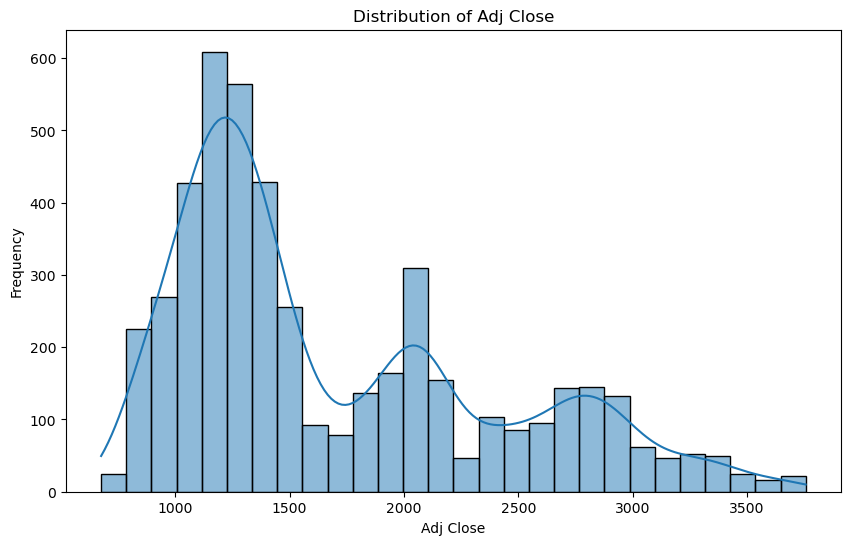

In [90]:
check_distribution(sp500_d)

In [91]:
#look at the correlated data:
#features_paiplot(sp500_d)
#correlation(sp500_d, 'Adj Close')
#rolling_correlation(sp500, 'Adj Close')


In [92]:
print("Is data normal?", is_normal(sp500_d))

Is data normal? {'SMA': False, 'WMA': False, 'MACD': False, 'RSI': False, '%K_fast': False, '%D_fast': False, '%D_slow': False, 'Bollinger Diff': False, 'WPR': False, 'OBV': False, 'ROC': False, 'ATR': False, 'MFI': False, 'Chaikin_Oscillator': False, 'Adj Close': False}


In [93]:
outliers_counts = count_outliers_iqr_df(sp500_d)
print("Number of outliers in each column:")
print(outliers_counts)

Number of outliers in each column:
{'SMA': 29, 'WMA': 32, 'MACD': 267, 'RSI': 3, '%K_fast': 0, '%D_fast': 0, '%D_slow': 0, 'Bollinger Diff': 322, 'WPR': 0, 'OBV': 0, 'ROC': 238, 'ATR': 392, 'MFI': 8, 'Chaikin_Oscillator': 66, 'Adj Close': 40}


In [94]:
#choosing features:
chosen_features = ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']


In [ ]:
# In the context of regression tasks like this one (since SVR is a Support Vector Machine for regression),
# where the target variable is continuous (e.g., log returns), a model score less than 0 typically indicates 
# that the model is performing poorly and making predictions that are worse than simply using the mean or another
# basic statistical measure as the prediction for all samples.

Arima Model without Time Sieries Decomposition

In [ ]:
#clean the data from na values & pick the columns
data = sp500.copy()
data = drop_nan(data)
data = data.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

In [ ]:
# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(data['Adj Close'], seasonal=False, trace=True)
print(model.summary())

Best Arima Model is ARIMA(2,1,2)

The data Splitted 80% - 20% - Walk Forward on test (the predictions added to the train)
The Method of WF as it was used for other Models WAS NOT USED HERE!!!
The Predictions were really bad when it was tried

In [ ]:
dataset_ex_df = data['Adj Close']
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:].index, test, label='Real')
plt.plot(dataset_ex_df.iloc[size:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
#Evaluate
mae = mean_absolute_error(test,predictions)
mse = mean_squared_error(test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
mape = mean_absolute_percentage_error(test,predictions)
# Visualize predictions vs. actual values
plt.scatter(test,predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

print(f'Mean Absolute Error: {mae}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\nR-squared: {r2}')
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
# Plotting
# Create traces
trace1 = go.Scatter(x=dataset_ex_df.iloc[size:].index, y=test, mode='lines', name='Adjusted Close')
trace2 = go.Scatter(x=dataset_ex_df.iloc[size:].index, y=predictions, mode='lines', name='Adj_Close_diff')

# Create figure
fig = go.Figure()

# Add traces to figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout
fig.update_layout(title='ARIMA Predictions vs Actual Values',
                  xaxis_title='Time',
                  yaxis_title='USD',
                  hovermode='x unified')

# Show plot
fig.show()

## Class For All Models

In [142]:
class TimeSeriesModels:
    def __init__(self, k=5, svr_kernel='rbf', C=1.0, gamma=0.1, degree=3, rf_n_estimators=100, rf_max_features=4, 
                 rf_criterion = 'squared_error', gbm_n_estimators=100, gbm_criterion='squared_error',
                 gbm_loss='squared_error', gbm_n_features='sqrt', rf_warm_start=False):

        self.k = k
        self.svr_kernel = svr_kernel
        self.gamma = gamma
        self.degree = degree
        self.C = C
        self.rf_n_estimators = rf_n_estimators
        self.rf_max_features = rf_max_features
        self.rf_criterion = rf_criterion
        self.rf_warm_start=rf_warm_start
        self.gbm_n_estimators = gbm_n_estimators
        self.gbm_criterion = gbm_criterion
        self.gbm_loss = gbm_loss
        self.gbm_n_features = gbm_n_features

        # Initialize models
        self.knn_model = KNeighborsRegressor(n_neighbors=self.k)
        self.svr_model = SVR(kernel=self.svr_kernel, gamma=self.gamma, degree=self.degree, C=self.C)
        self.rf_model = RandomForestRegressor(n_estimators=self.rf_n_estimators,
                         max_features=self.rf_max_features, criterion=self.rf_criterion, bootstrap=False, warm_start=self.rf_warm_start)
        self.gbm_model = GradientBoostingRegressor(n_estimators=self.gbm_n_estimators, 
                                                   criterion=self.gbm_criterion, loss=self.gbm_loss
                                                   ,max_features=self.gbm_n_features)
        self.lr_model = LinearRegression()

    def knn_fit(self, dfX, vY):
        self.knn_model.fit(dfX, vY)

    def svr_fit(self, dfX, vY):
        self.svr_model.fit(dfX, vY)

    def rf_fit(self, dfX, vY):
        self.rf_model.fit(dfX, vY)

    def gbm_fit(self, dfX, vY):
        self.gbm_model.fit(dfX, vY)
    
    def lr_fit(self, dfX, vY):
        self.lr_model.fit(dfX, vY)

    def knn_predict(self, dfX):
        return self.knn_model.predict(dfX)

    def svr_predict(self, dfX):
        return self.svr_model.predict(dfX)

    def rf_predict(self, dfX):
        return self.rf_model.predict(dfX)

    def gbm_predict(self, dfX):
        return self.gbm_model.predict(dfX)
    
    def lr_predict(self, dfX):
        return self.lr_model.predict(dfX)

    def knn_score(self, dfX, vY):
        return self.knn_model.score(dfX, vY)

    def svr_score(self, dfX, vY):
        return self.svr_model.score(dfX, vY)

    def rf_score(self, dfX, vY):
        return self.rf_model.score(dfX, vY)

    def gbm_score(self, dfX, vY):
        return self.gbm_model.score(dfX, vY)
    
    def lr_score(self, dfX, vY):
        return self.lr_model.score(dfX, vY)

    def knn_train(self, splits, col_drop):
        predictions = []
        
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.knn_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.knn_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def svr_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.svr_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.svr_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def rf_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.rf_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.rf_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations

    def gbm_train(self, splits, col_drop):
        predictions = []
        evaluations = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.gbm_model.fit(X_train, y_train)
            X_test = out_of_sample.drop(columns=[col_drop])
            y_test = out_of_sample[col_drop]
            prediction = self.gbm_model.predict(X_test)
            predictions.extend(prediction)
            evaluations.extend(self.evaluate(y_test, prediction))  #Append evaluation results as a single list
        return (predictions, evaluations)# Return both predictions and evaluations
    
    def lr_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.lr_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.lr_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def evaluate(self, y_true, y_pred):
        self.mae = mean_absolute_error(y_true, y_pred)
        self.mse = mean_squared_error(y_true, y_pred)
        self.rmse = np.sqrt(self.mse)
        self.r2 = r2_score(y_true, y_pred)
        self.mape = mean_absolute_percentage_error(y_true, y_pred)

        return (self.mae, self.mse, self.rmse, self.r2, self.mape)

Data to perform Optemization

In [143]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_nan(sp500_d)
sp500_d = sp500_d.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

In [144]:
#Split the data
sp500_d = truncate_before_wf(sp500_d, 320, 80)
splits = walk_forward_validation(sp500_d, 320, 80)

Grid Search SVR Optimization

In [ ]:
lC      = [1, 10, 50, 100]
lKernel = ['poly', 'rbf','linear']
lgamma      = ['scale', 'auto', 0.1, 0.01, 0.001]
ldegree = [1, 2, 3, 4]

In [ ]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(lKernel) * len(lC) * len(lgamma) * len(ldegree)
dData   = {'kernel': [], 'C': [], 'gamma':[], 'degree':[]}

for ii, kernel in enumerate(lKernel):
    for jj, paramC in enumerate(lC):
        for kk, gamma in enumerate(lgamma):
            for cc, degree in enumerate(ldegree):
                dData['kernel'].append(kernel)
                dData['C'].append(paramC)
                dData['gamma'].append(gamma)
                dData['degree'].append(degree)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)


In [ ]:
Model = TimeSeriesModels(svr_kernel='rbf', C=1.0, gamma=0.1, degree=3)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 320
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]
for ii in range(numComb):
    kernel    = dfModelScore.loc[ii, 'kernel']
    paramC          = dfModelScore.loc[ii, 'C']
    gamma          = dfModelScore.loc[ii, 'gamma']
    degree          = dfModelScore.loc[ii, 'degree']


    print(f'Processing model {ii + 1:03d} out of {numComb}')

    Model = TimeSeriesModels(svr_kernel=kernel, C=paramC, gamma=gamma, degree=degree)
    predictions = Model.svr_train(splits, 'Adj Close')
    
    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[ii, 'MAE'] = mae
    dfModelScore.loc[ii, 'MSE'] = mse
    dfModelScore.loc[ii, 'RMSE'] = rmse
    dfModelScore.loc[ii, 'R2'] = r2
    dfModelScore.loc[ii, 'MAPE'] = mape

Find Best Model Score or SVR Kernel

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'MSE', 'RMSE', 'R2', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['RMSE'].idxmin()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['kernel', 'C', 'gamma', 'degree']]

# Print the parameters of the best model
print("Best Model Parameters:")
print(best_model_params)

Train the best SVR Model

In [ ]:
Model = TimeSeriesModels(svr_kernel='linear', C=100, gamma='scale', degree=3)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 320
predictions = Model.svr_train(splits, 'Adj Close')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predictions'] = predictions

In [ ]:
# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 320
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]

# Calculate evaluation metrics
mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)

# Update the 'R2' column in dfModelScore with the calculated R2 score
dfModelScore.loc['MAE'] = mae
dfModelScore.loc['MSE'] = mse
dfModelScore.loc['RMSE'] = rmse
dfModelScore.loc['R2'] = r2
dfModelScore.loc['MAPE'] = mape

KNN Optimization

In [ ]:
dData   = {'K': []}

#===============================================================#

dfModelScore = pd.DataFrame(data = dData)

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 320
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]
for kk in range(10):
    print(f'Processing model {kk + 1:03d} out of {10}')

    Model = TimeSeriesModels(k=kk + 1)
    predictions = Model.knn_train(splits, 'Adj Close')
    
    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[kk, 'k'] = kk + 1
    dfModelScore.loc[kk, 'MAE'] = mae
    dfModelScore.loc[kk, 'MSE'] = mse
    dfModelScore.loc[kk, 'RMSE'] = rmse
    dfModelScore.loc[kk, 'R2'] = r2
    dfModelScore.loc[kk, 'MAPE'] = mape

#===============================================================#

Find best KNN Model

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'MSE', 'RMSE', 'R2', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['R2'].idxmax()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['k']]

# Print the parameters of the best model
print("Best Model Parameters:")
print(best_model_params)

Train the best KNN Model

In [ ]:
Model = TimeSeriesModels(k=2)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 320
predictions = Model.knn_train(splits, 'Adj Close')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predictions'] = predictions

LinearRegressor - no hyperparameters

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 320
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]

predictions = Model.lr_train(splits, 'Adj Close')

# Calculate evaluation metrics
mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)

# Update the 'R2' column in dfModelScore with the calculated R2 score
dfModelScore.loc['MAE'] = mae
dfModelScore.loc['MSE'] = mse
dfModelScore.loc['RMSE'] = rmse
dfModelScore.loc['R2'] = r2
dfModelScore.loc['MAPE'] = mape

#===============================================================#

Random Forest Optimization

In [ ]:
m_features = ['sqrt', 'log2', 4, 5, 6, 7]
#criterion = ['squared_error', 'MAE']
criterion = ['squared_error']
n_estimators = [100, 150, 200] #number of threes in the forest (100 default)

In [ ]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(m_features) * len(criterion) * len(n_estimators)
dData   = {'max_features': [], 'criterion': [], 'n_estimators':[]}

for ii, feature in enumerate(m_features):
    for jj, cri in enumerate(criterion):
        for kk, est in enumerate(n_estimators):
            dData['max_features'].append(feature)
            dData['criterion'].append(cri)
            dData['n_estimators'].append(est)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 320
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]
for ii in range(numComb):
    rf_n_feature = dfModelScore.loc[ii, 'max_features']
    rf_criterion = dfModelScore.loc[ii, 'criterion']
    rf_n_est = dfModelScore.loc[ii, 'n_estimators']

    print(f'Processing model {ii + 1:03d} out of {numComb}')
    Model = TimeSeriesModels(rf_n_estimators=rf_n_est, rf_max_features=rf_n_feature ,rf_criterion = rf_criterion, rf_warm_start=True)
    predictions = Model.rf_train(splits, 'Adj Close')
    
    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[ii, 'MAE'] = mae
    dfModelScore.loc[ii, 'MSE'] = mse
    dfModelScore.loc[ii, 'RMSE'] = rmse
    dfModelScore.loc[ii, 'R2'] = r2
    dfModelScore.loc[ii, 'MAPE'] = mape

#===============================================================#

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'MSE', 'RMSE', 'R2', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['RMSE'].idxmin()
#best_model_index = dfModelScore['R2'].idxmax()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['max_features', 'criterion', 'n_estimators']]

# Print the parameters of the best model
print("Best Model Parameters:")
print(best_model_params)

In [ ]:
dfModelScore.describe()

Train the best Random Forest model

In [ ]:
Model = TimeSeriesModels(rf_n_estimators=150, rf_max_features=7)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 320
predictions = Model.rf_train(splits, 'Adj Close')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predictions'] = predictions


Gradient Boosting Optimization

In [131]:
L_loss = ['squared_error']
#L_loss = ['squared_error', 'absolute_error', 'huber']
L_criterion = ['squared_error']
#L_criterion = ['friedman_mse', 'squared_error']
L_n_estimators = [100, 150, 200] #number of threes in the forest (100 default)
L_m_features = ['sqrt', 'log2', 5, 7]

In [132]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(L_loss) * len(L_criterion) * len(L_n_estimators) *len(L_m_features)
dData   = {'loss': [], 'criterion': [], 'n_estimators':[], 'm_features':[]}

for ii, lss in enumerate(L_loss):
    for jj, cri in enumerate(L_criterion):
        for kk, est in enumerate(L_n_estimators):
            for kk, feature in enumerate(L_m_features):
                dData['loss'].append(lss)
                dData['criterion'].append(cri)
                dData['n_estimators'].append(est)
                dData['m_features'].append(feature)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 320
vY = sp500_d['Adj Close'].values
vY = vY[index_dropped:]
for ii in range(numComb):
    gbm_lo = dfModelScore.loc[ii, 'loss']
    gbm_cri = dfModelScore.loc[ii, 'criterion']
    gbm_n_est = dfModelScore.loc[ii, 'n_estimators']
    gbm_feat = dfModelScore.loc[ii, 'm_features']

    print(f'Processing model {ii + 1:03d} out of {numComb}')
    Model = TimeSeriesModels(gbm_n_estimators=gbm_n_est, gbm_criterion=gbm_cri, gbm_loss=gbm_lo
                                                   ,gbm_n_features=gbm_feat)
    predictions, _ = Model.gbm_train(splits, 'Adj Close')

    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[ii, 'MAE'] = mae
    dfModelScore.loc[ii, 'MSE'] = mse
    dfModelScore.loc[ii, 'RMSE'] = rmse
    dfModelScore.loc[ii, 'R2'] = r2
    dfModelScore.loc[ii, 'MAPE'] = mape

#===============================================================#

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'MSE', 'RMSE', 'R2', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
#best_model_index = dfModelScore['MeanScore'].idxmin()
#best_model_index = dfModelScore['R2'].idxmax()
best_model_index = dfModelScore['RMSE'].idxmin()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['loss', 'criterion', 'n_estimators', 'm_features']]

# Print the parameters of the best model
print("Best Model Parameters:")
print(best_model_params)

Train Gradient Boosting Model

In [146]:
Model = TimeSeriesModels(gbm_n_estimators=200)
# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 320
predictions, _ = Model.gbm_train(splits, 'Adj Close')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predictions'] = predictions


In [134]:
#rearrange the evaluations from each iteration
eval = [eval[i:i+5] for i in range(0, len(eval), 5)]
c_names = ['MAE', 'MSE', 'RMSE', 'R2', 'MAPE']
eval = pd.DataFrame(eval, columns=c_names)

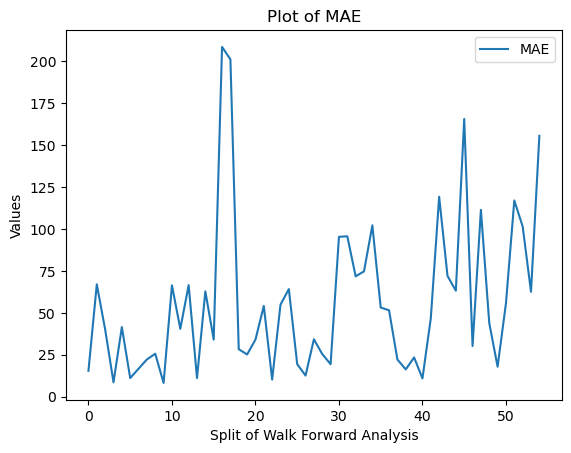

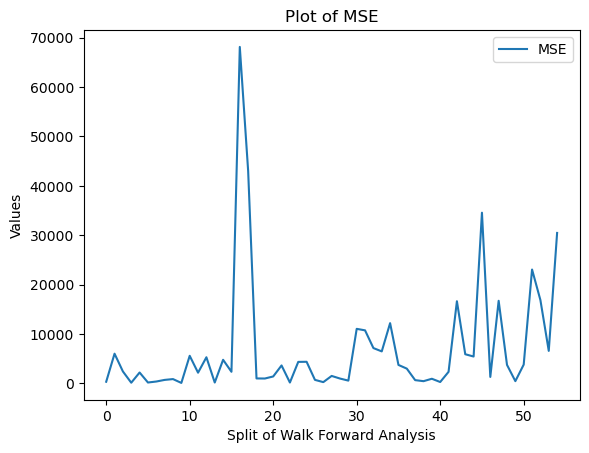

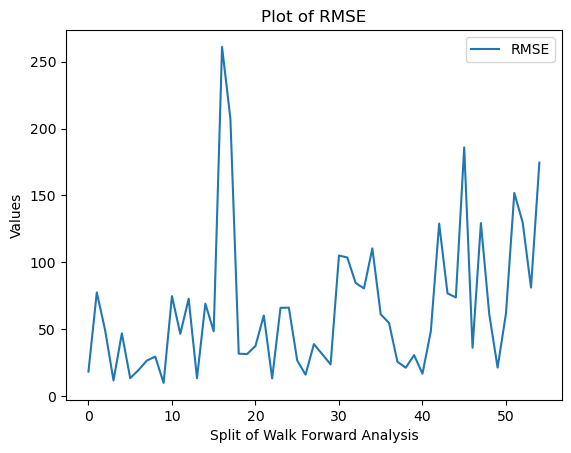

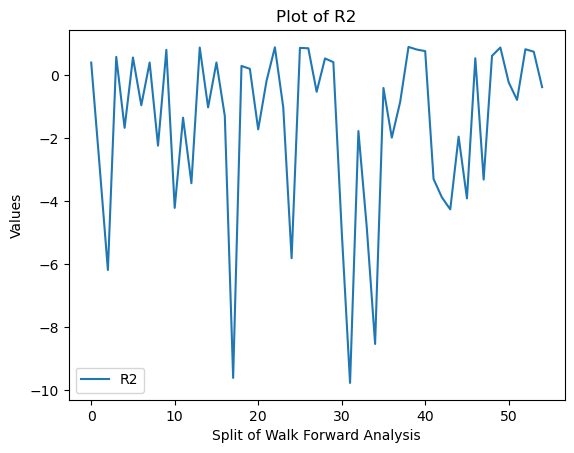

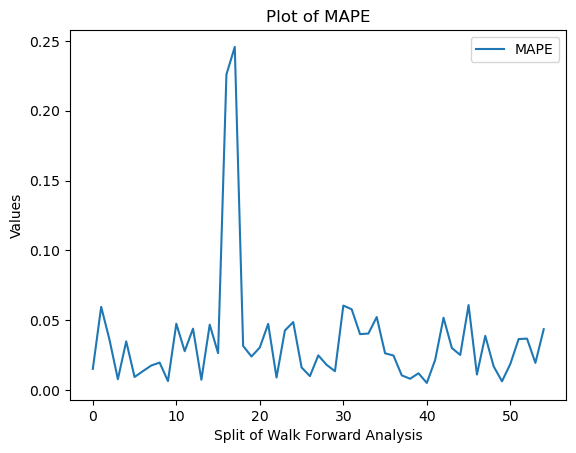

In [135]:
#Plot the evaluations for each iteration of the WF
for column in eval.columns:
    plt.figure()  # Create a new figure for each plot
    plt.plot(eval.index, eval[column], label=column)  # Plot the column
    plt.xlabel('Split of Walk Forward Analysis')
    plt.ylabel('Values')
    plt.title(f'Plot of {column}')  # Add title with column name
    plt.legend()  # Show legend
    plt.show()  # Show the plot

# Results Visualization

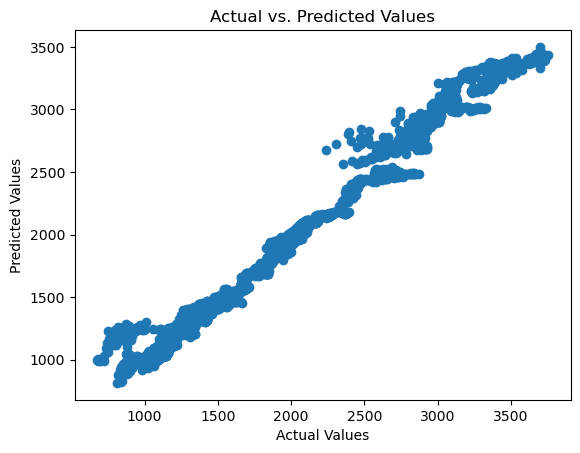

Mean Absolute Error: 60.17320545914088
Mean Squared Error: 8640.540329261903
Root Mean Squared Error: 92.95450677219424
R-squared: 0.9819338140681594
Mean Absolute Percentage Error (MAPE): 0.038855420580929584


In [147]:
# Visualize predictions vs. actual values
plt.scatter(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predictions'] )
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

mae = mean_absolute_error(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predictions'] )
mse = mean_squared_error(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predictions'] )
rmse = np.sqrt(mse)
r2 = r2_score(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predictions'] )
mape = mean_absolute_percentage_error(sp500_d_includes_results['Adj Close'], sp500_d_includes_results['Predictions'] )

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

In [148]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'Adj Close'
feature2 = 'Predictions'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Model - log_return Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()

Convert Predected values to returns

In [ ]:
analyze = sp500_d_includes_results.copy()


In [ ]:
analyze = calculate_returns(analyze, 'Adj Close', 'Returns')
analyze = calculate_returns(analyze, 'Predictions', 'Predicted Returns')

Check the Returns Distribution 

In [ ]:
check_distribution(analyze, 'Predicted Returns')

In [ ]:
check_distribution(analyze, 'Returns')

In [ ]:
q1, q2, q3 = calculate_quantiles(analyze, 'Predicted Returns')

print("Q1 (25th percentile):\n", q1)
print("\nQ2 (50th percentile - Median):\n", q2)
print("\nQ3 (75th percentile):\n", q3)

Calculate Trading Signals

In [ ]:
calculate_signal(analyze, 'Returns', 'Signal')

In [ ]:
calculate_signal(analyze, 'Predicted Returns', 'Predicted Signal')

In [ ]:
analyze.tail()

In [ ]:
feature1 = 'Returns'
feature2 = 'Predicted Returns'

# Create line plot
fig = go.Figure()

# Add line plot for feature1
fig.add_trace(go.Scatter(
    x=analyze.index,  # Assuming the index represents x-axis values
    y=analyze[feature1],
    mode='lines',
    name=feature1
))

# Add line plot for feature2
fig.add_trace(go.Scatter(
    x=analyze.index,  # Assuming the index represents x-axis values
    y=analyze[feature2],
    mode='lines',
    name=feature2
))

# Calculate quartiles for feature1
q1_feature1 = analyze[feature1].quantile(0.25)
q3_feature1 = analyze[feature1].quantile(0.75)

# Calculate quartiles for feature2
q1_feature2 = analyze[feature2].quantile(0.25)
q3_feature2 = analyze[feature2].quantile(0.75)

# Add horizontal lines for quartiles for feature1
fig.add_hline(y=q1_feature1, line_dash="dash", line_color="green", annotation_text=f'{feature1} Q1: {q1_feature1}', annotation_position="bottom right")
fig.add_hline(y=q3_feature1, line_dash="dash", line_color="orange", annotation_text=f'{feature1} Q3: {q3_feature1}', annotation_position="top right")

# Add horizontal lines for quartiles for feature2
fig.add_hline(y=q1_feature2, line_dash="dash", line_color="black", annotation_text=f'{feature2} Q1: {q1_feature2}', annotation_position="bottom left")
fig.add_hline(y=q3_feature2, line_dash="dash", line_color="white", annotation_text=f'{feature2} Q3: {q3_feature2}', annotation_position="top left")

# Customize layout
fig.update_layout(
    title='Model - Predicted Returns Vs. Returns - WF 320,80',
    xaxis=dict(title='Time Index'),  # Customize x-axis label
    yaxis=dict(title='Returns'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()

In [ ]:
#calculate bench mark buy and hold returns
analyze = calculate_buy_and_hold_returns(analyze, 'Adj Close', 'Returns BH')

Sharpe Ratio / Information Ratio / Maximum Drowdown: returns vs predected

In [ ]:
sharp_true = calculate_sharpe_ratio(analyze['Returns'])
sharp_pred = calculate_sharpe_ratio(analyze['Predicted Returns'])
sharp_BH = calculate_sharpe_ratio(analyze['Returns BH'])
ir_true = calculate_ir(analyze['Returns'],  analyze['Returns BH'])
ir_pred = calculate_ir(analyze['Predicted Returns'],  analyze['Returns BH'])
ir_BH = calculate_ir(analyze['Returns BH'],  analyze['Returns BH'])
mdd_true = calculate_mdd(analyze['Returns'])
mdd_pred = calculate_mdd(analyze['Predicted Returns'])
mdd_BH = calculate_mdd(analyze['Returns BH'])

In [ ]:
print(sharp_true, sharp_pred, sharp_BH, ir_true, ir_pred, ir_BH, mdd_true, mdd_pred, mdd_BH)

## Download Validation Set

In [149]:
sp500_data_n = yf.download('^GSPC', start='2021-01-01', end='2023-01-01')

[*********************100%%**********************]  1 of 1 completed


In [150]:
#try 
dfX = sp500_data_n.copy()
dfX = technical_indicators(dfX)
dfX.iloc[:, 6:] = dfX.iloc[:, 6:].apply(feature_transform, axis=0)
dfX = drop_nan(dfX)
dfX = dfX.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]


C:\Users\Nagham\AppData\Local\Temp\ipykernel_20928\2195036028.py:4: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Date
2021-01-04   -0.562583
2021-01-05   -0.506700
2021-01-06   -0.432887
2021-01-07   -0.370819
2021-01-08   -0.312721
                ...   
2022-12-23   -0.919385
2022-12-27   -0.956270
2022-12-28   -0.993803
2022-12-29   -0.957242
2022-12-30   -0.993514
Name: OBV, Length: 503, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [151]:
feat_dfX = dfX.drop(columns='Adj Close')

In [152]:

dfX['Predicted Adj Close'] = Model.gbm_predict(feat_dfX)

In [ ]:
dfX.head()

In [153]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'Adj Close'
feature2 = 'Predicted Adj Close'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Model - log_return Vs. Predictions',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()

In [154]:
dfX = calculate_returns(dfX, 'Adj Close', 'Returns')
dfX = calculate_returns(dfX, 'Predicted Adj Close', 'Predicted Returns')

In [157]:
calculate_signal(dfX, 'Predicted Returns', 'Predicted Signal')
calculate_signal(dfX, 'Returns', 'Signal')

,SMA,WMA,MACD,RSI,%K_fast,%D_fast,%D_slow,Bollinger Diff,WPR,OBV,ROC,ATR,MFI,Chaikin_Oscillator,Adj Close,Predicted Adj Close,Returns,Predicted Returns,Predicted Signal,Signal
Date,,,,,,,,,,,,,,,,,,,,
2021-02-03,-0.729421,-0.720012,0.277045,0.006168,0.539201,-0.094814,-0.303049,-0.798306,0.539201,-0.183859,0.197700,-0.450188,-0.005909,-0.355737,3830.169922,2734.180705,0.001009,0.005543,0,0
2021-02-04,-0.721777,-0.705327,0.320273,0.142253,0.992373,0.269367,-0.081656,-0.792952,0.992373,-0.124468,0.223122,-0.442240,0.148763,-0.112710,3871.739990,2766.829298,0.010853,0.011941,1,1
2021-02-05,-0.710504,-0.688151,0.363311,0.254885,0.922870,0.601289,0.258919,-0.750438,0.922870,-0.065075,0.129482,-0.473084,0.307132,0.021974,3886.830078,2777.013252,0.003897,0.003681,0,0
2021-02-08,-0.692309,-0.665823,0.416147,0.251185,0.998376,0.833205,0.572718,-0.682346,0.998376,-0.008494,0.195788,-0.474635,0.304699,0.258648,3915.590088,2792.364951,0.007399,0.005528,0,1
2021-02-09,-0.678439,-0.646717,0.450768,0.121142,0.936493,0.930657,0.796325,-0.634675,0.936493,-0.064101,0.213733,-0.518685,0.305602,0.329687,3911.229980,2807.596063,-0.001114,0.005455,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.531365,-0.571299,-0.097109,-0.401936,-0.522513,-0.708905,-0.818104,-0.235783,-0.522513,-0.919385,-0.164991,-0.111012,-0.498165,-0.158912,3844.820068,2571.262690,0.005868,0.005717,0,0
2022-12-27,-0.552308,-0.590562,-0.126545,-0.326518,-0.615062,-0.664710,-0.743210,-0.192831,-0.615062,-0.956270,-0.269163,-0.189690,-0.352144,-0.094745,3829.250000,2534.782549,-0.004050,-0.014188,-1,0
2022-12-28,-0.571824,-0.617716,-0.182016,-0.396398,-0.888668,-0.674469,-0.695956,-0.117579,-0.888668,-0.993803,-0.311354,-0.137993,-0.332987,-0.209445,3783.219971,2517.895024,-0.012021,-0.006662,0,-1


In [ ]:
dfX.head()

In [158]:
feature1 = 'Returns'
feature2 = 'Predicted Returns'

# Create line plot
fig = go.Figure()

# Add line plot for feature1
fig.add_trace(go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature1],
    mode='lines',
    name=feature1
))

# Add line plot for feature2
fig.add_trace(go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature2],
    mode='lines',
    name=feature2
))

# Calculate quartiles for feature1
q1_feature1 = dfX[feature1].quantile(0.25)
q3_feature1 = dfX[feature1].quantile(0.75)

# Calculate quartiles for feature2
q1_feature2 = dfX[feature2].quantile(0.25)
q3_feature2 = dfX[feature2].quantile(0.75)

# Add horizontal lines for quartiles for feature1
fig.add_hline(y=q1_feature1, line_dash="dash", line_color="green", annotation_text=f'{feature1} Q1: {q1_feature1}', annotation_position="bottom right")
fig.add_hline(y=q3_feature1, line_dash="dash", line_color="orange", annotation_text=f'{feature1} Q3: {q3_feature1}', annotation_position="top right")

# Add horizontal lines for quartiles for feature2
fig.add_hline(y=q1_feature2, line_dash="dash", line_color="black", annotation_text=f'{feature2} Q1: {q1_feature2}', annotation_position="bottom left")
fig.add_hline(y=q3_feature2, line_dash="dash", line_color="white", annotation_text=f'{feature2} Q3: {q3_feature2}', annotation_position="top left")

# Customize layout
fig.update_layout(
    title='Model - Predicted Returns Vs. Returns - WF 600,200',
    xaxis=dict(title='Time Index'),  # Customize x-axis label
    yaxis=dict(title='Returns'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()

In [159]:
mae = mean_absolute_error(dfX['Adj Close'], dfX['Predicted Adj Close'] )
mse = mean_squared_error(dfX['Adj Close'], dfX['Predicted Adj Close'] )
rmse = np.sqrt(mse)
r2 = r2_score(dfX['Adj Close'], dfX['Predicted Adj Close'] )
mape = mean_absolute_percentage_error(dfX['Adj Close'], dfX['Predicted Adj Close'] )

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error: 1413.6410646011286
Mean Squared Error: 2029468.0599914233
Root Mean Squared Error: 1424.593998299664
R-squared: -22.033601986873094
Mean Absolute Percentage Error (MAPE): 0.33613133269917933


Mean Absolute Error: 1556.229927897793
Mean Squared Error: 2452416.250634323
Root Mean Squared Error: 1566.0192369936976
R-squared: -26.833884620726344
Mean Absolute Percentage Error (MAPE): 0.36939950873652055

In [161]:
accuracy = calculate_accuracy(dfX['Signal'], dfX['Predicted Signal'])
print(accuracy)

0.6327800829875518


## New code for WF optimization

In [95]:
#clean the data from na values & pick the columns
sp500_WFO = sp500.copy()
sp500_WFO = drop_nan(sp500_WFO)
sp500_WFO = sp500_WFO.loc[:, ['SMA','WMA', 'MACD', 'RSI', '%K_fast', '%D_fast', '%D_slow', 'Bollinger Diff',
                    'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator', 'Adj Close']]

In [96]:
from sklearn.model_selection import GridSearchCV


# Assume 'data' contains your historical data, including 'date', 'adjusted_close', and any features

# Define the number of time windows and their sizes
num_windows = 12
window_size = len(sp500_WFO) // num_windows

# Initialize lists to store performance metrics
mse_scores = []
all_pred = []

# Perform Walk Forward Analysis
for i in range(num_windows - 1):  # Iterate through each time window
    # Define start and end indices for the current time window
    start_index = i * window_size
    end_index = (i + 1) * window_size

    # Extract in-sample and out-of-sample data
    in_sample_data = sp500_WFO[start_index:end_index]
    out_of_sample_data = sp500_WFO[end_index:end_index + window_size]

    # Extract features and target variable from the data
    X_train = in_sample_data.drop(columns='Adj Close')
    y_train = in_sample_data['Adj Close']
    X_test = out_of_sample_data.drop(columns='Adj Close')
    y_test = out_of_sample_data['Adj Close']

    # Define hyperparameters to search
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.5]
    }

    # Initialize Gradient Boosting model
    model = GradientBoostingRegressor()
    
    # Define time series split for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # Perform GridSearchCV for hyperparameter optimization and Pass time series split to GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    ## Get the best model from GridSearchCV
    best_hyperparameters = grid_search.best_params_

    # Make predictions on the out-of-sample data
    predictions = best_model.predict(X_test)
    all_pred.append(predictions)
    # Calculate Mean Squared Error (MSE) as the performance metric
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

# Print MSE scores for each time window
print("MSE Scores for Each Time Window:", mse_scores)

print("Best Hyper Params:", best_hyperparameters)

# Calculate and print average MSE score
average_mse = np.mean(mse_scores)
print("Average MSE:", average_mse)

MSE Scores for Each Time Window: [940.9200194577612, 3745.8825877188056, 14307.75689067808, 125346.31624637394, 1356.8894954266516, 2916.1056932579813, 91578.095330471, 6169.484791916748, 50082.08748588093, 41079.06383086065, 115125.36326843404]
Average MSE: 41149.81505822514


In [47]:
# Define a list of hyperparameters to try
n_estimators_list = [50, 100, 200]
max_depth_list = [3, 5, 7]
learning_rate_list = [0.01, 0.1, 0.5]

best_mse = float('inf')
best_hyperparameters = {}

# Perform Walk Forward Analysis
for i in range(num_windows - 1):  # Iterate through each time window
    # Define start and end indices for the current time window
    start_index = i * window_size
    end_index = (i + 1) * window_size

    # Extract in-sample and out-of-sample data
    in_sample_data = sp500_WFO[start_index:end_index]
    out_of_sample_data = sp500_WFO[end_index:end_index + window_size]

    # Extract features and target variable from the data
    X_train = in_sample_data.drop(columns='Adj Close')
    y_train = in_sample_data['Adj Close']
    X_test = out_of_sample_data.drop(columns='Adj Close')
    y_test = out_of_sample_data['Adj Close']
    
    # Iterate over all combinations of hyperparameters
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            for learning_rate in learning_rate_list:
                # Initialize Gradient Boosting model with current hyperparameters
                model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

                # Fit the model on the training data
                model.fit(X_train, y_train)

                # Make predictions on the test data
                predictions = model.predict(X_test)

                # Calculate Mean Squared Error (MSE) as the performance metric
                mse = mean_squared_error(y_test, predictions)

                # Check if current model has lower MSE than the best model so far
                if mse < best_mse:
                    best_mse = mse
                    best_hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

# Use the best hyperparameters to train the final model
best_model = GradientBoostingRegressor(**best_hyperparameters)
best_model.fit(X_train, y_train)

# Make predictions on the entire test data using the best model
final_predictions = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE) using the best model
final_mse = mean_squared_error(y_test, final_predictions)

print("Best Hyperparameters:", best_hyperparameters)
print("Final MSE:", final_mse)


Best Hyperparameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Final MSE: 114253.86580439263


In [99]:
arr = np.array(all_pred)

all_pred_f = np.concatenate(arr, axis=None)


In [103]:
np.shape(all_pred_f)

(4367,)

In [104]:
sp500_WFO['Predictions'] = np.nan
sp500_WFO.iloc[:4367, sp500_WFO.columns.get_loc('Predictions')] = all_pred_f
sp500_WFO = drop_nan(sp500_WFO)

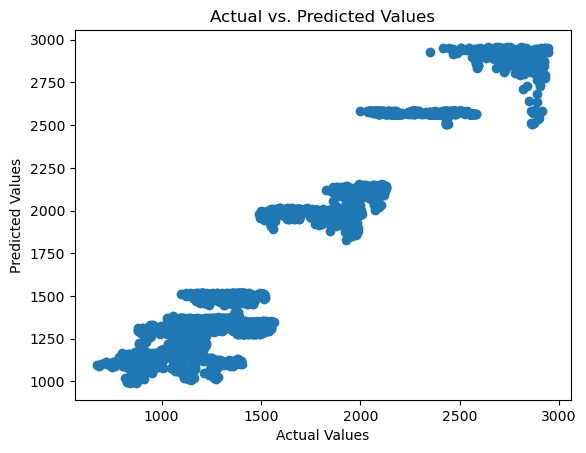

Mean Absolute Error: 161.1607693830537
Mean Squared Error: 39478.58179452409
Root Mean Squared Error: 198.69217849357858
R-squared: 0.8750145612870263
Mean Absolute Percentage Error (MAPE): 0.11734577754748886


In [105]:
# Visualize predictions vs. actual values
plt.scatter(sp500_WFO['Adj Close'], sp500_WFO['Predictions'] )
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

mae = mean_absolute_error(sp500_WFO['Adj Close'], sp500_WFO['Predictions'] )
mse = mean_squared_error(sp500_WFO['Adj Close'], sp500_WFO['Predictions'] )
rmse = np.sqrt(mse)
r2 = r2_score(sp500_WFO['Adj Close'], sp500_WFO['Predictions'] )
mape = mean_absolute_percentage_error(sp500_WFO['Adj Close'], sp500_WFO['Predictions'] )

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

In [109]:
dfX['Predicted Adj Close'] = best_model.predict(feat_dfX)

In [110]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'Adj Close'
feature2 = 'Predicted Adj Close'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Model - log_return Vs. Predictions',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()

In [112]:
dfX = calculate_returns(dfX, 'Predicted Adj Close', 'predicted_returns')
dfX = calculate_returns(dfX, 'Adj Close', 'true_returns')
dfX = calculate_signal(dfX, 'Predicted Adj Close', 'predicted_signals')
dfX = calculate_signal(dfX, 'Adj Close', 'true_signals')

In [123]:
dfX.describe()

,SMA,WMA,MACD,RSI,%K_fast,%D_fast,%D_slow,Bollinger Diff,WPR,OBV,ROC,ATR,MFI,Chaikin_Oscillator,Adj Close,Predicted Adj Close,predicted_returns,true_returns,predicted_signals,true_signals
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,0.003057,0.004898,0.133912,0.031556,0.203905,0.183700,0.183619,-0.300854,0.203905,0.076267,0.054942,-0.225436,-0.002335,-0.079412,4203.192928,2646.963000,0.000002,0.000083,0.000000,0.000000
std,0.534022,0.526387,0.460547,0.409691,0.660036,0.627751,0.622692,0.446426,0.660036,0.457504,0.357161,0.488658,0.371044,0.400320,297.140030,159.127261,0.013225,0.012312,0.709308,0.709308
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3577.030029,2371.628527,-0.054305,-0.043237,-1.000000,-1.000000
25%,-0.476377,-0.472307,-0.187005,-0.299524,-0.385586,-0.379140,-0.364573,-0.665748,-0.385586,-0.177530,-0.171317,-0.670000,-0.271949,-0.379675,3941.315002,2543.019480,-0.003789,-0.007177,-0.750000,-0.750000
50%,-0.018024,-0.006247,0.272290,0.076684,0.302841,0.303089,0.316548,-0.408024,0.302841,0.071536,0.111512,-0.267467,0.036443,-0.094677,4196.520020,2599.004638,0.000103,-0.000200,0.000000,0.000000
75%,0.455376,0.444953,0.462009,0.305969,0.823462,0.788325,0.779477,-0.033501,0.823462,0.375201,0.268586,0.114786,0.257915,0.221755,4443.094849,2780.266932,0.005209,0.007352,0.750000,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4796.560059,2962.929953,0.037994,0.055434,1.000000,1.000000


In [114]:
mae = mean_absolute_error(dfX['Adj Close'], dfX['Predicted Adj Close'] )
mse = mean_squared_error(dfX['Adj Close'], dfX['Predicted Adj Close'] )
rmse = np.sqrt(mse)
r2 = r2_score(dfX['Adj Close'], dfX['Predicted Adj Close'] )
mape = mean_absolute_percentage_error(dfX['Adj Close'], dfX['Predicted Adj Close'] )

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error: 1556.229927897793
Mean Squared Error: 2452416.250634323
Root Mean Squared Error: 1566.0192369936976
R-squared: -26.833884620726344
Mean Absolute Percentage Error (MAPE): 0.36939950873652055


In [117]:
feature1 = 'true_returns'
feature2 = 'predicted_returns'

# Create line plot
fig = go.Figure()

# Add line plot for feature1
fig.add_trace(go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature1],
    mode='lines',
    name=feature1
))

# Add line plot for feature2
fig.add_trace(go.Scatter(
    x=dfX.index,  # Assuming the index represents x-axis values
    y=dfX[feature2],
    mode='lines',
    name=feature2
))

# Calculate quartiles for feature1
q1_feature1 = dfX[feature1].quantile(0.25)
q3_feature1 = dfX[feature1].quantile(0.75)

# Calculate quartiles for feature2
q1_feature2 = dfX[feature2].quantile(0.25)
q3_feature2 = dfX[feature2].quantile(0.75)

# Add horizontal lines for quartiles for feature1
fig.add_hline(y=q1_feature1, line_dash="dash", line_color="green", annotation_text=f'{feature1} Q1: {q1_feature1}', annotation_position="bottom right")
fig.add_hline(y=q3_feature1, line_dash="dash", line_color="orange", annotation_text=f'{feature1} Q3: {q3_feature1}', annotation_position="top right")

# Add horizontal lines for quartiles for feature2
fig.add_hline(y=q1_feature2, line_dash="dash", line_color="black", annotation_text=f'{feature2} Q1: {q1_feature2}', annotation_position="bottom left")
fig.add_hline(y=q3_feature2, line_dash="dash", line_color="white", annotation_text=f'{feature2} Q3: {q3_feature2}', annotation_position="top left")

# Customize layout
fig.update_layout(
    title='Model - Predicted Returns Vs. Returns - WF 200,20',
    xaxis=dict(title='Time Index'),  # Customize x-axis label
    yaxis=dict(title='Returns'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()

In [124]:
accuracy = calculate_accuracy(dfX['true_signals'], dfX['predicted_signals'])

In [125]:
accuracy

0.7842323651452282